In [42]:
# Imports
import torch
import jovian
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [43]:
# Hyperparameters
batch_size = 256
learning_rate = 1e-5

# Other constants
input_size = 28*28
num_classes = 26

In [44]:
#dataset = pd.read_csv('sign_mnist_train.csv')
#testdataset = pd.read_csv('sign_mnist_test.csv')
#num_rows = dataset.shape[0]

# obter os dados de treinamento
dataTrain = pd.read_csv('sign_mnist_train.csv')
# obter os rotulos dos dados de treinamento
yTrain = dataTrain['label'].values
# remover os rotulos dos dados de treinamento
dataTrain.drop('label', axis = 1, inplace = True)
#numero de linhas (n. exemplos)
num_rows = dataTrain.shape[0]

# obter os dados de teste
dataTest = pd.read_csv('sign_mnist_test.csv')
# obter os rotulos dos dados de teste
yTest = dataTest['label'].values
#remover os rotulos dos dados de teste
dataTest.drop('label', axis = 1, inplace = True)
# verificar os dados de teste para verificar os rotulos de classe e as colunas que representam os pixeis
dataTest.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [45]:
# converter os dados de treinamento para um array
xTrain = dataTrain.values

# converter os dados de teste para um array
xTest = dataTest.values

In [46]:
letters = dict(enumerate(string.ascii_uppercase))
print(letters)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Text(0.5, 0.98, 'Some images from train data set')

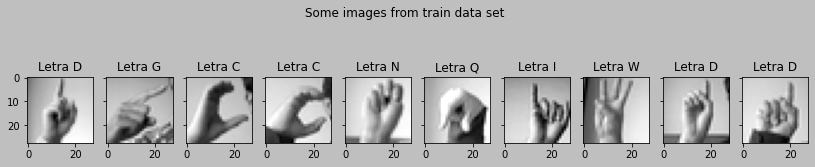

In [47]:
#Mostrar algumas imagem e respetivas letras
plt.style.use('grayscale')
fig, axs = plt.subplots(1, 10, figsize=(14, 3), sharey=True)
for i in range(10): 
    axs[i].imshow(xTrain[i].reshape(28,28),cmap='gray')
    axs[i].set_title(f'Letra {letters[yTrain[i].item()]}')
fig.suptitle('Some images from train data set')

In [48]:
inputs = torch.from_numpy(xTrain).float()
targets = torch.from_numpy(yTrain).long()
testinputs = torch.from_numpy(xTest).float()
testtargets = torch.from_numpy(yTest).long()

In [49]:
# Training validation & test dataset
dataset = TensorDataset(inputs, targets)
testdataset = TensorDataset(testinputs, testtargets)

# Let's use 15% of our training dataset to validate our model
val_percent = 0.15
val_size = int(num_rows * val_percent) #4118 para validar os dados
train_size = num_rows - val_size  #23337 para dados de traino
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #train dados dataset e validação de dados do dataset

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(testdataset, batch_size*2)

In [54]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [56]:
evaluate(model, val_loader) #{'val_loss': 253.74566650390625, 'val_acc': 0.04417219012975693}

{'val_loss': 260.8264465332031, 'val_acc': 0.0349392369389534}

In [57]:
history = fit(50, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 456.1820, val_acc: 0.1158
Epoch [1], val_loss: 285.9148, val_acc: 0.1794
Epoch [2], val_loss: 152.7149, val_acc: 0.2695
Epoch [3], val_loss: 196.7854, val_acc: 0.1372
Epoch [4], val_loss: 125.4642, val_acc: 0.3585
Epoch [5], val_loss: 159.2451, val_acc: 0.2862
Epoch [6], val_loss: 89.2176, val_acc: 0.3403
Epoch [7], val_loss: 104.9358, val_acc: 0.3534
Epoch [8], val_loss: 62.3225, val_acc: 0.3927
Epoch [9], val_loss: 91.6697, val_acc: 0.3555
Epoch [10], val_loss: 129.2735, val_acc: 0.1460
Epoch [11], val_loss: 31.2252, val_acc: 0.5706
Epoch [12], val_loss: 46.1440, val_acc: 0.4293
Epoch [13], val_loss: 40.3666, val_acc: 0.4697
Epoch [14], val_loss: 91.8829, val_acc: 0.2329
Epoch [15], val_loss: 24.1804, val_acc: 0.5720
Epoch [16], val_loss: 10.8216, val_acc: 0.6943
Epoch [17], val_loss: 44.7724, val_acc: 0.4816
Epoch [18], val_loss: 34.5393, val_acc: 0.5231
Epoch [19], val_loss: 24.4783, val_acc: 0.6526
Epoch [20], val_loss: 25.9999, val_acc: 0.6166
Epoch [21], val

Text(0.5, 1.0, 'Accurary Evolution (error=1e-4 ; epochs=50)')

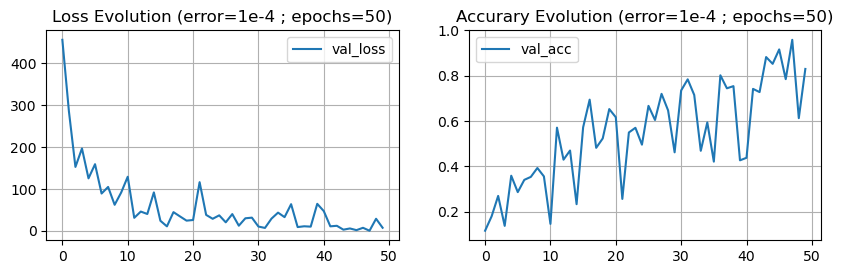

In [92]:
val_loss = [r['val_loss'] for r in history]
val_acc = [r['val_acc'] for r in history]

plt.style.use('default')
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.grid()
plt.title('Loss Evolution (error=1e-4 ; epochs=50)')

plt.subplot(2,2,2)
plt.plot(val_acc, label = 'val_acc')
plt.legend()
plt.grid()
plt.title('Accurary Evolution (error=1e-4 ; epochs=50)')

In [59]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
print(result)
#{'val_loss': 12.54245376586914, 'val_acc': 0.690625011920929}

{'val_loss': 21.09128761291504, 'val_acc': 0.6162760257720947}


In [60]:
model_2 = MnistModel()

In [61]:
# Evaluating the model prior to training
evaluate(model_2, val_loader)  
#{'val_loss': 152.07281494140625, 'val_acc': 0.02864583395421505}

{'val_loss': 152.07281494140625, 'val_acc': 0.02864583395421505}

In [62]:
history_2 = fit(100, 1e-4, model_2, train_loader, val_loader)

Epoch [0], val_loss: 403.7296, val_acc: 0.1226
Epoch [1], val_loss: 270.7702, val_acc: 0.1726
Epoch [2], val_loss: 199.3126, val_acc: 0.1408
Epoch [3], val_loss: 213.2979, val_acc: 0.1293
Epoch [4], val_loss: 241.2430, val_acc: 0.0988
Epoch [5], val_loss: 134.7844, val_acc: 0.2125
Epoch [6], val_loss: 130.4736, val_acc: 0.3015
Epoch [7], val_loss: 88.6437, val_acc: 0.4038
Epoch [8], val_loss: 119.2174, val_acc: 0.1665
Epoch [9], val_loss: 75.3684, val_acc: 0.3896
Epoch [10], val_loss: 70.0566, val_acc: 0.4169
Epoch [11], val_loss: 71.2500, val_acc: 0.4412
Epoch [12], val_loss: 39.3701, val_acc: 0.4958
Epoch [13], val_loss: 36.7329, val_acc: 0.4952
Epoch [14], val_loss: 70.2212, val_acc: 0.3847
Epoch [15], val_loss: 33.7924, val_acc: 0.4833
Epoch [16], val_loss: 103.7014, val_acc: 0.3430
Epoch [17], val_loss: 50.1433, val_acc: 0.4611
Epoch [18], val_loss: 70.0530, val_acc: 0.3870
Epoch [19], val_loss: 48.6014, val_acc: 0.4349
Epoch [20], val_loss: 24.9747, val_acc: 0.5776
Epoch [21], va

Text(0.5, 1.0, 'Accurary Evolution (error=1e-4 ; epochs=100)')

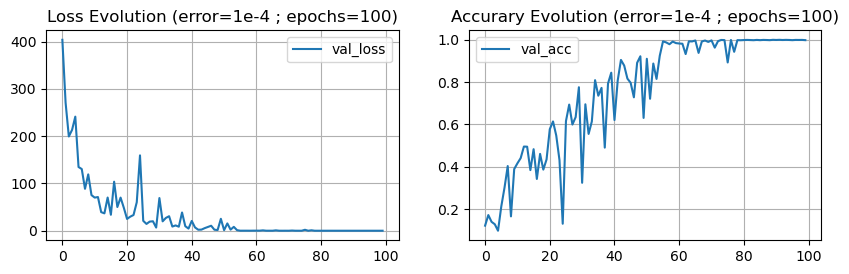

In [93]:
val_loss = [r['val_loss'] for r in history_2]
val_acc = [r['val_acc'] for r in history_2]

plt.style.use('default')
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.grid()
plt.title('Loss Evolution (error=1e-4 ; epochs=100)')

plt.subplot(2,2,2)
plt.plot(val_acc, label = 'val_acc')
plt.legend()
plt.grid()
plt.title('Accurary Evolution (error=1e-4 ; epochs=100)')

In [65]:
# Evaluate on test dataset
result_2 = evaluate(model_2, test_loader)
print(result_2)
#{'val_loss': 12.581381797790527, 'val_acc': 0.678515613079071}

{'val_loss': 12.581381797790527, 'val_acc': 0.678515613079071}


In [66]:
model_3 = MnistModel()

In [67]:
history_3 = fit(50, 1e-5, model_3, train_loader, val_loader)

Epoch [0], val_loss: 33.0992, val_acc: 0.0994
Epoch [1], val_loss: 25.2309, val_acc: 0.1383
Epoch [2], val_loss: 22.7582, val_acc: 0.1751
Epoch [3], val_loss: 19.6603, val_acc: 0.1990
Epoch [4], val_loss: 18.4003, val_acc: 0.2194
Epoch [5], val_loss: 14.8722, val_acc: 0.2608
Epoch [6], val_loss: 14.0296, val_acc: 0.3025
Epoch [7], val_loss: 13.7321, val_acc: 0.3048
Epoch [8], val_loss: 11.4791, val_acc: 0.3506
Epoch [9], val_loss: 11.2769, val_acc: 0.3518
Epoch [10], val_loss: 9.7970, val_acc: 0.3660
Epoch [11], val_loss: 10.8486, val_acc: 0.3648
Epoch [12], val_loss: 9.7313, val_acc: 0.3690
Epoch [13], val_loss: 8.8286, val_acc: 0.3940
Epoch [14], val_loss: 9.2376, val_acc: 0.3762
Epoch [15], val_loss: 7.2905, val_acc: 0.4450
Epoch [16], val_loss: 9.7987, val_acc: 0.3956
Epoch [17], val_loss: 7.8550, val_acc: 0.4452
Epoch [18], val_loss: 7.4606, val_acc: 0.4613
Epoch [19], val_loss: 8.2171, val_acc: 0.4552
Epoch [20], val_loss: 7.6064, val_acc: 0.4582
Epoch [21], val_loss: 5.0452, val

Text(0.5, 1.0, 'Accurary Evolution (error=1e-5 ; epochs=50)')

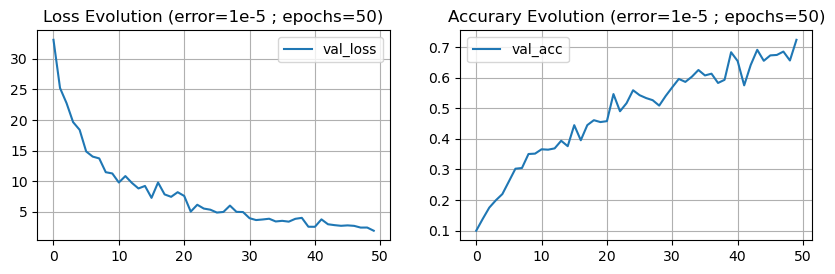

In [94]:
val_loss = [r['val_loss'] for r in history_3]
val_acc = [r['val_acc'] for r in history_3]

plt.style.use('default')
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.grid()
plt.title('Loss Evolution (error=1e-5 ; epochs=50)')

plt.subplot(2,2,2)
plt.plot(val_acc, label = 'val_acc')
plt.legend()
plt.grid()
plt.title('Accurary Evolution (error=1e-5 ; epochs=50)')

In [69]:
# Evaluate on test dataset
result_3 = evaluate(model_3, test_loader)
print(result_3)
#{'val_loss': 6.081923961639404, 'val_acc': 0.5412760376930237}

{'val_loss': 6.081923961639404, 'val_acc': 0.5412760376930237}


In [70]:
model_4 = MnistModel()

In [73]:
history_4 = fit(100, 1e-5, model_4, train_loader, val_loader)

Epoch [0], val_loss: 0.2738, val_acc: 0.9253
Epoch [1], val_loss: 0.2938, val_acc: 0.9192
Epoch [2], val_loss: 0.2120, val_acc: 0.9410
Epoch [3], val_loss: 0.2604, val_acc: 0.9198
Epoch [4], val_loss: 0.1840, val_acc: 0.9495
Epoch [5], val_loss: 0.3098, val_acc: 0.9118
Epoch [6], val_loss: 0.4143, val_acc: 0.8565
Epoch [7], val_loss: 0.2137, val_acc: 0.9302
Epoch [8], val_loss: 0.2097, val_acc: 0.9477
Epoch [9], val_loss: 0.1901, val_acc: 0.9433
Epoch [10], val_loss: 0.5627, val_acc: 0.8670
Epoch [11], val_loss: 0.2510, val_acc: 0.9197
Epoch [12], val_loss: 0.3439, val_acc: 0.8942
Epoch [13], val_loss: 0.1263, val_acc: 0.9718
Epoch [14], val_loss: 0.1312, val_acc: 0.9698
Epoch [15], val_loss: 0.1631, val_acc: 0.9499
Epoch [16], val_loss: 0.1431, val_acc: 0.9648
Epoch [17], val_loss: 0.1331, val_acc: 0.9652
Epoch [18], val_loss: 0.1670, val_acc: 0.9570
Epoch [19], val_loss: 0.1618, val_acc: 0.9574
Epoch [20], val_loss: 0.1185, val_acc: 0.9694
Epoch [21], val_loss: 0.2863, val_acc: 0.900

Text(0.5, 1.0, 'Accurary Evolution (error=1e-5 ; epochs=100)')

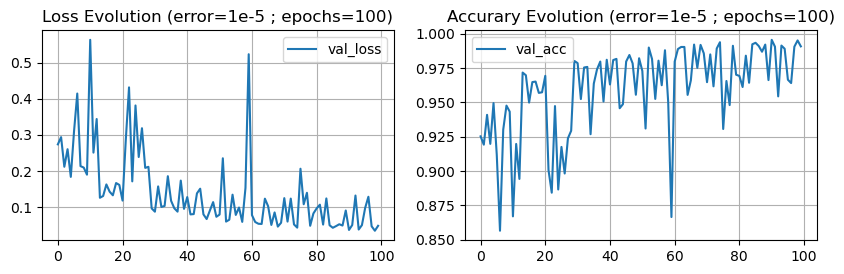

In [95]:
val_loss = [r['val_loss'] for r in history_4]
val_acc = [r['val_acc'] for r in history_4]

plt.style.use('default')
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.grid()
plt.title('Loss Evolution (error=1e-5 ; epochs=100)')

plt.subplot(2,2,2)
plt.plot(val_acc, label = 'val_acc')
plt.legend()
plt.grid()
plt.title('Accurary Evolution (error=1e-5 ; epochs=100)')

In [96]:
# Evaluate on test dataset
result_4 = evaluate(model_4, test_loader)
print(result_4)
#{'val_loss': 5.151068210601807, 'val_acc': 0.5307291746139526}

{'val_loss': 5.3881707191467285, 'val_acc': 0.5119791626930237}


Using the Model to Predict Images:

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

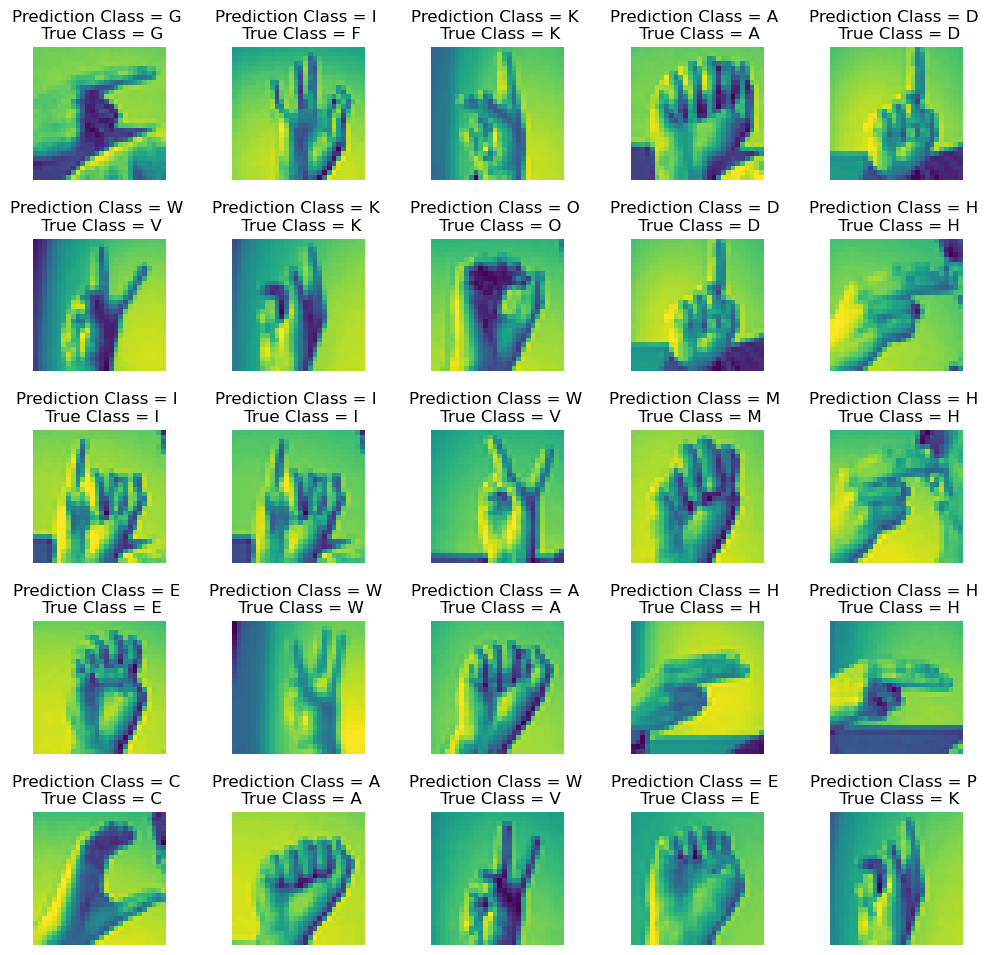

In [97]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, L * W):
    img, label = testdataset[i]
    axes[i].imshow(img.reshape(28,28)) 
    axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(letters[predict_image(img, model)], letters[label.item()])) 
    axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5)  #falha 5/25

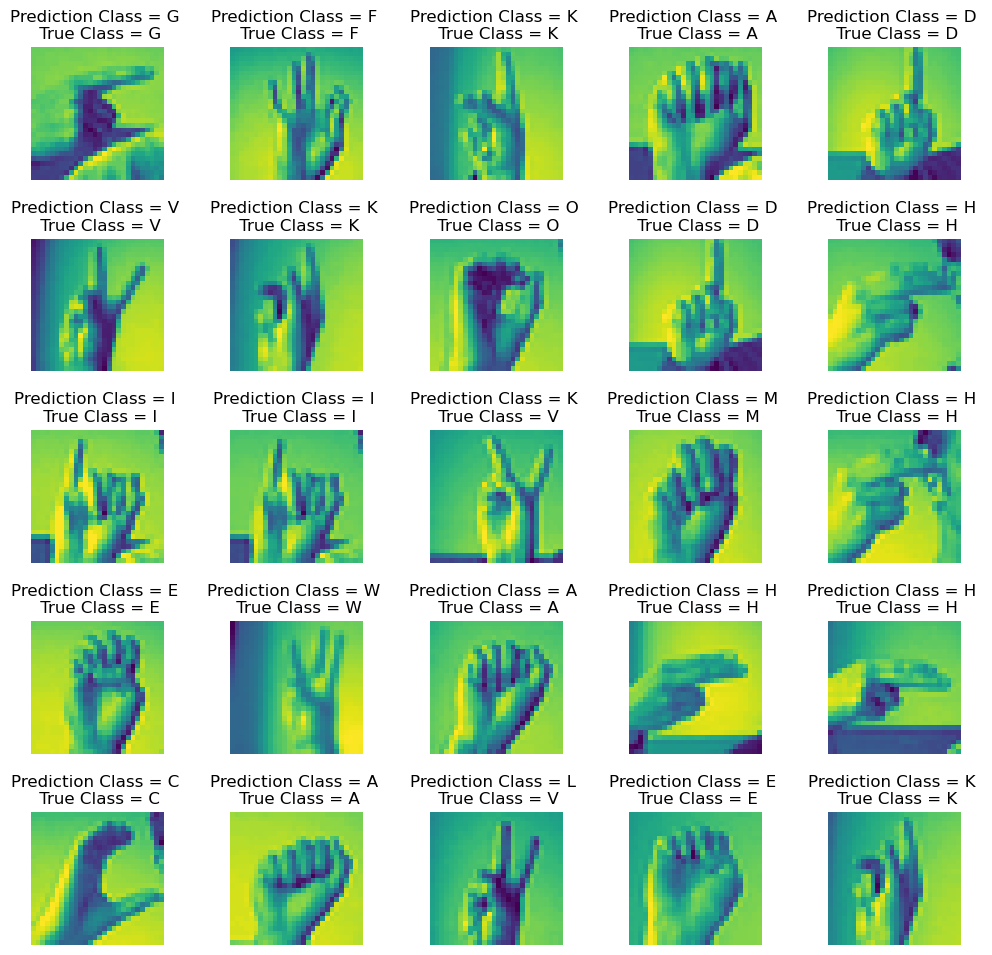

In [98]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, L * W):
    img, label = testdataset[i]
    axes[i].imshow(img.reshape(28,28)) 
    axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(letters[predict_image(img, model_2)], letters[label.item()])) 
    axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5) #falha 2/25

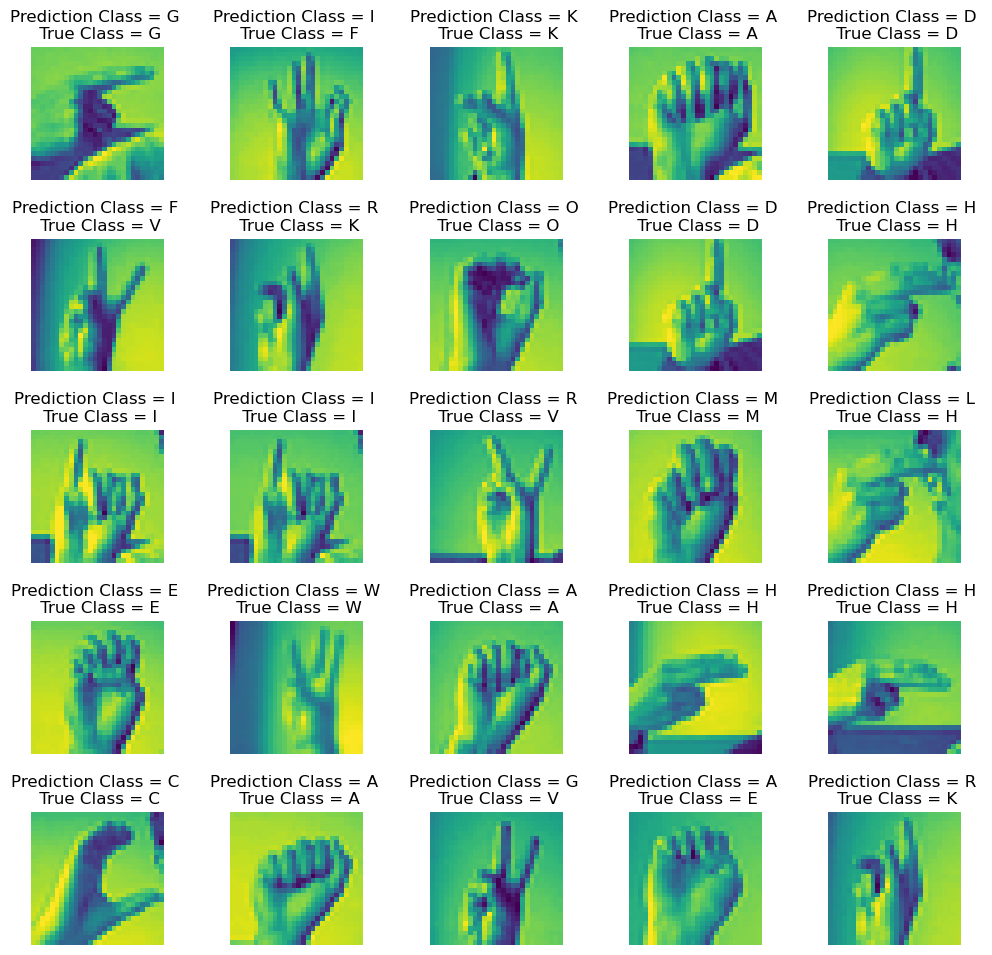

In [101]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, L * W):
    img, label = testdataset[i]
    axes[i].imshow(img.reshape(28,28)) 
    axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(letters[predict_image(img, model_3)], letters[label.item()])) 
    axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5) #falha 9/25

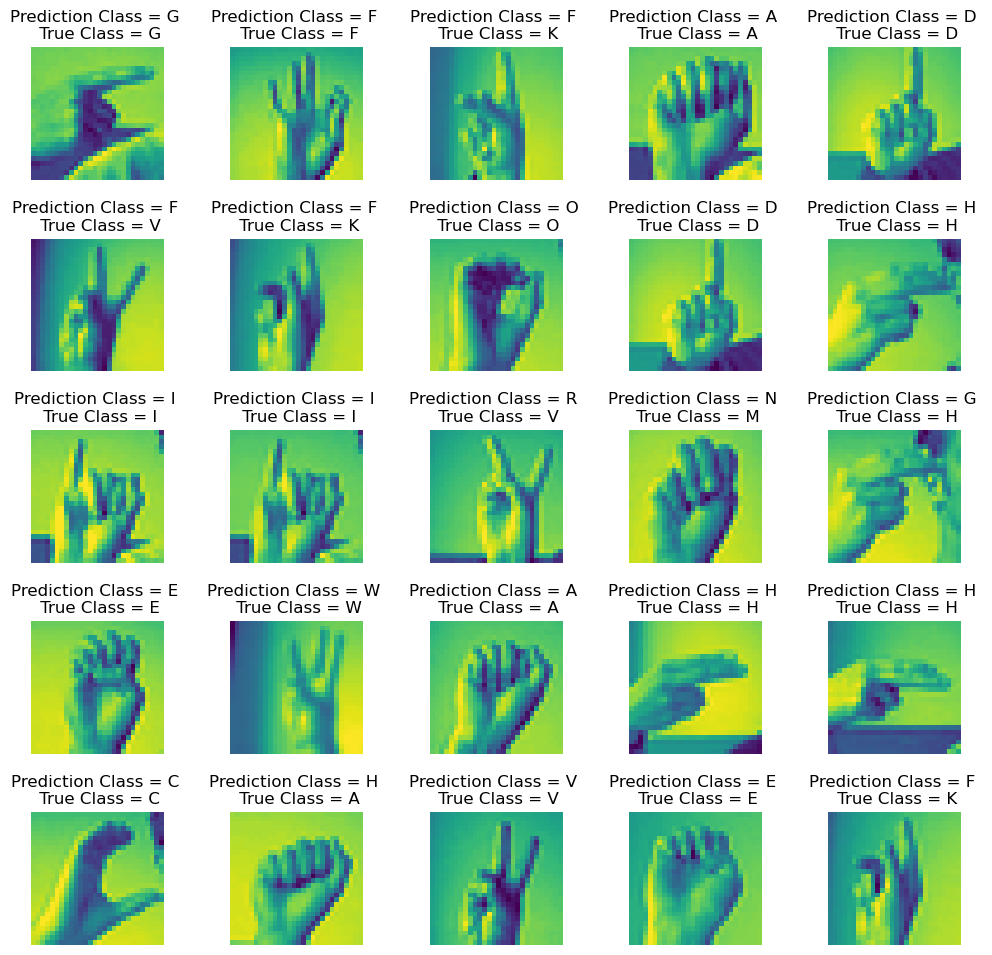

In [103]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, L * W):
    img, label = testdataset[i]
    axes[i].imshow(img.reshape(28,28)) 
    axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(letters[predict_image(img, model_4)], letters[label.item()])) 
    axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5) #falha 8/25

In [ ]:
# Here the model parameters are saved so that we dont have to train the model next time
torch.save(model_2.state_dict(), 'mnist-logistic.pth')

In [ ]:
# Let's look at the model parameters
model_2.state_dict()